
### dataset = Crack 500



## Loading the important libraries and Dataset

In [1]:
! nvidia-smi

Mon Sep 28 18:20:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 37%   33C    P8    19W / 250W |      0MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:5E:00.0 Off |                  N/A |
| 36%   34C    P8     9W / 250W |      0MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
!pip install albumentations
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE

     |████████████████████████████████| 117 kB 557 kB/s eta 0:00:01
     |████████████████████████████████| 948 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 5.7 MB/s eta 0:00:01
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65162 sha256=c9c03b3345d494b715ce188f6243e012d6aaba443a76df347b627d51c315ed86
  Stored in directory: /root/.cache/pip/wheels/38/db/df/d6cb0be184075a7799c1fd79240c389c16f51dfe18dc3332fa
Successfully built albumentations


In [5]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
import os
import zipfile
#local_zip = '/content/drive/My Drive/Crack/CRACK500.zip'
local_zip = '/home/adip/dbHdd/datasets/crack/CRACK500.zip'
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall()
#zip_ref.close()
print("Done")

Done


### Loading the data and splitting it into training and validation set.

In [8]:
#train_image_dir = r'/content/CRACK500/traindata/image'
#train_mask_dir = r'/content/CRACK500/traindata/mask'

#valid_image_dir = '/content/CRACK500/valdata/image'
#valid_mask_dir = '/content/CRACK500/valdata/mask'

#test_image_dir = '/content/CRACK500/testdata/image'
#test_mask_dir = '/content/CRACK500/testdata/mask'

train_image_dir = '/data/datasets/crack/Crack500/traindata/image'
train_mask_dir = '/data/datasets/crack/Crack500/traindata/mask'

valid_image_dir = '/data/datasets/crack/Crack500/valdata/image'
valid_mask_dir = '/data/datasets/crack/Crack500/valdata/mask'

test_image_dir = '/data/datasets/crack/Crack500/testdata/image'
test_mask_dir = '/data/datasets/crack/Crack500/testdata/mask'

In [9]:
#test_image_dir = '/content/CRACK500_CROP/testcrop/image'
#test_mask_dir = '/content/CRACK500_CROP/testcrop/mask'
test_image_dir = '/data/datasets/crack/Crack500/testcrop/image'
test_mask_dir = '/data/datasets/crack/Crack500/testcrop/mask'


train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])


test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))
print('\n')
print("Number of testing images : ", len(test_image_paths))
print("Number of testing masks : ", len(test_mask_paths))

Number of training images :  250
Number of training masks :  250


Number of testing images :  1124
Number of testing masks :  1124


In [10]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)
train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [11]:
# Splitting
train_image_files = train_image_paths[:150]
train_mask_files = train_mask_paths[:150]

valid_image_files = train_image_paths[150:]
valid_mask_files = train_mask_paths[150:]

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))


150 150
100 100


In [12]:
batch_size = 5
img_dim=(256, 256)

# Generator to load and augment the image batch wise

In [13]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(128, 128), augment=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augment = augment

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  augmentations = Compose(
    [                   
      Flip(p=0.7),
      Rotate(p=0.7),
      OneOf([
              RandomContrast(),
              RandomGamma(),
              RandomBrightness()
            ], p=0.3),
      OneOf([
              ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
              GridDistortion(),
              OpticalDistortion(distort_limit=2, shift_limit=0.5)
            ], p=0.3),
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (self.img_dim[1], self.img_dim[0])) for file_name in batch_x])
      batch_y = np.array([(cv2.resize(cv2.imread(file_name, -1), (self.img_dim[1], self.img_dim[0]))>0).astype(np.uint8) for file_name in batch_y])

      if self.augment is True:
        aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255, batch_y/1  

In [14]:
test1_generator=Generator(test_image_paths,test_mask_paths)


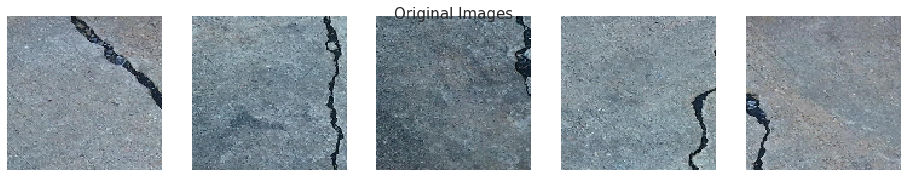

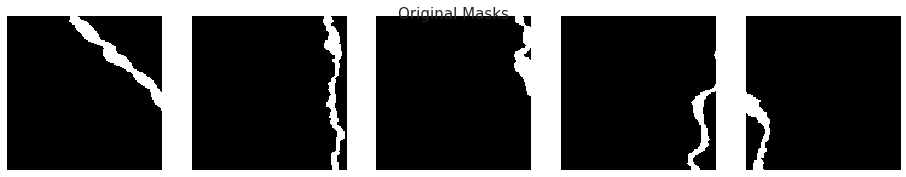

In [15]:
# Validation generator samples (Un-augmented)
for i, j in test1_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [16]:
train_generator = Generator(train_image_files, train_mask_files)
validation_generator = Generator(valid_image_files, valid_mask_files)


In [17]:
for i, j in train_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [18]:
for i, j in validation_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


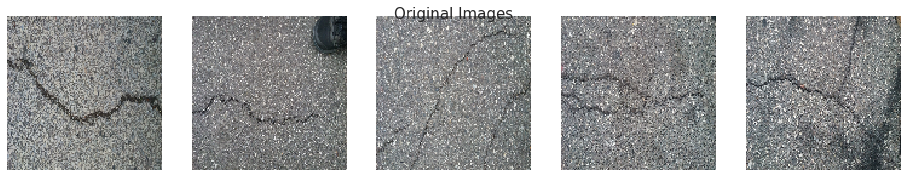

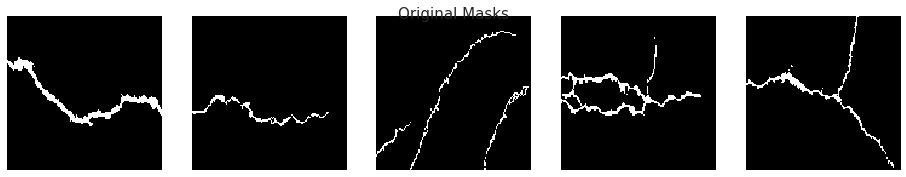

In [19]:
# Train generator samples (Un-augmented)
for i, j in train_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

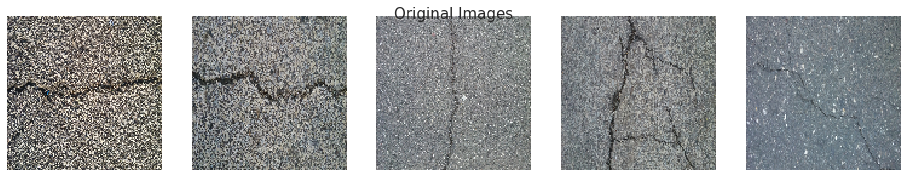

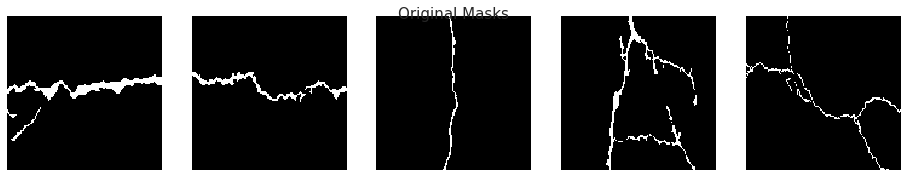

In [20]:
# Validation generator samples (Un-augmented)
for i, j in validation_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [21]:
tg = Generator(train_image_files, train_mask_files, batch_size, img_dim, augment = True)
vg = Generator(valid_image_files, valid_mask_files, batch_size, img_dim, augment = False)

In [22]:
for i, j in tg:
  break

print(i.shape)
print(j.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)


In [23]:
for i, j in vg:
  break

print(i.shape)
print(j.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)


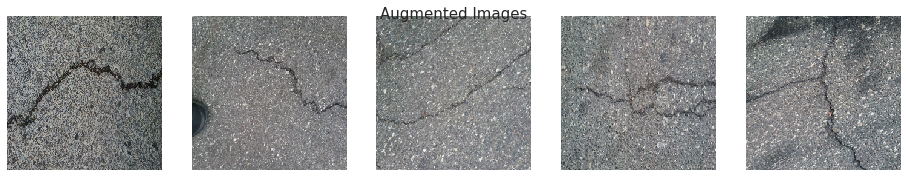

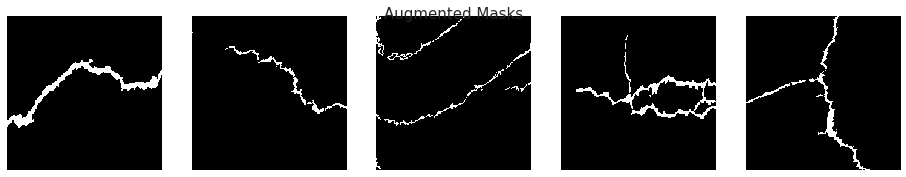

In [24]:
# Augmented train
for i, j in tg:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Model

In [25]:
import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Input, Activation, Concatenate
from keras.regularizers import l2

Using TensorFlow backend.


In [26]:
# BatchNormalization and Activation
def BN_Act(x, act = True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

In [27]:
#conv2d block
def conv2d_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    conv = BN_Act(x)
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(conv)
    return conv

In [28]:
#Fixed layer.
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
    conv = conv2d_block(conv, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    
    #skip
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([conv, shortcut])
    return output

In [29]:
# Residual Block
def residual_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    res = conv2d_block(x, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    res = conv2d_block(res, filters, kernel_size = kernel_size, padding = padding, strides = 1)
    
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([shortcut, res])
    return output

In [30]:
# Upsampling Concatenation block
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [31]:
# MODEL
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_dim[0], img_dim[1], 3))
    
    ## Encoder/downsampling/contracting path
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides = 2)
    e3 = residual_block(e2, f[2], strides = 2)
    e4 = residual_block(e3, f[3], strides = 2)
    e5 = residual_block(e4, f[4], strides = 2)
    
    ## Bridge/Bottleneck
    b0 = conv2d_block(e5, f[4], strides = 1)
    b1 = conv2d_block(b0, f[4], strides = 1)
    
    ## Decoder/upsampling/expansive path
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = Conv2D(1, (1, 1), padding = "same", activation = "sigmoid")(d4)
    model = Model(inputs, outputs)
    return model

In [32]:
K.clear_session()
model = ResUNet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

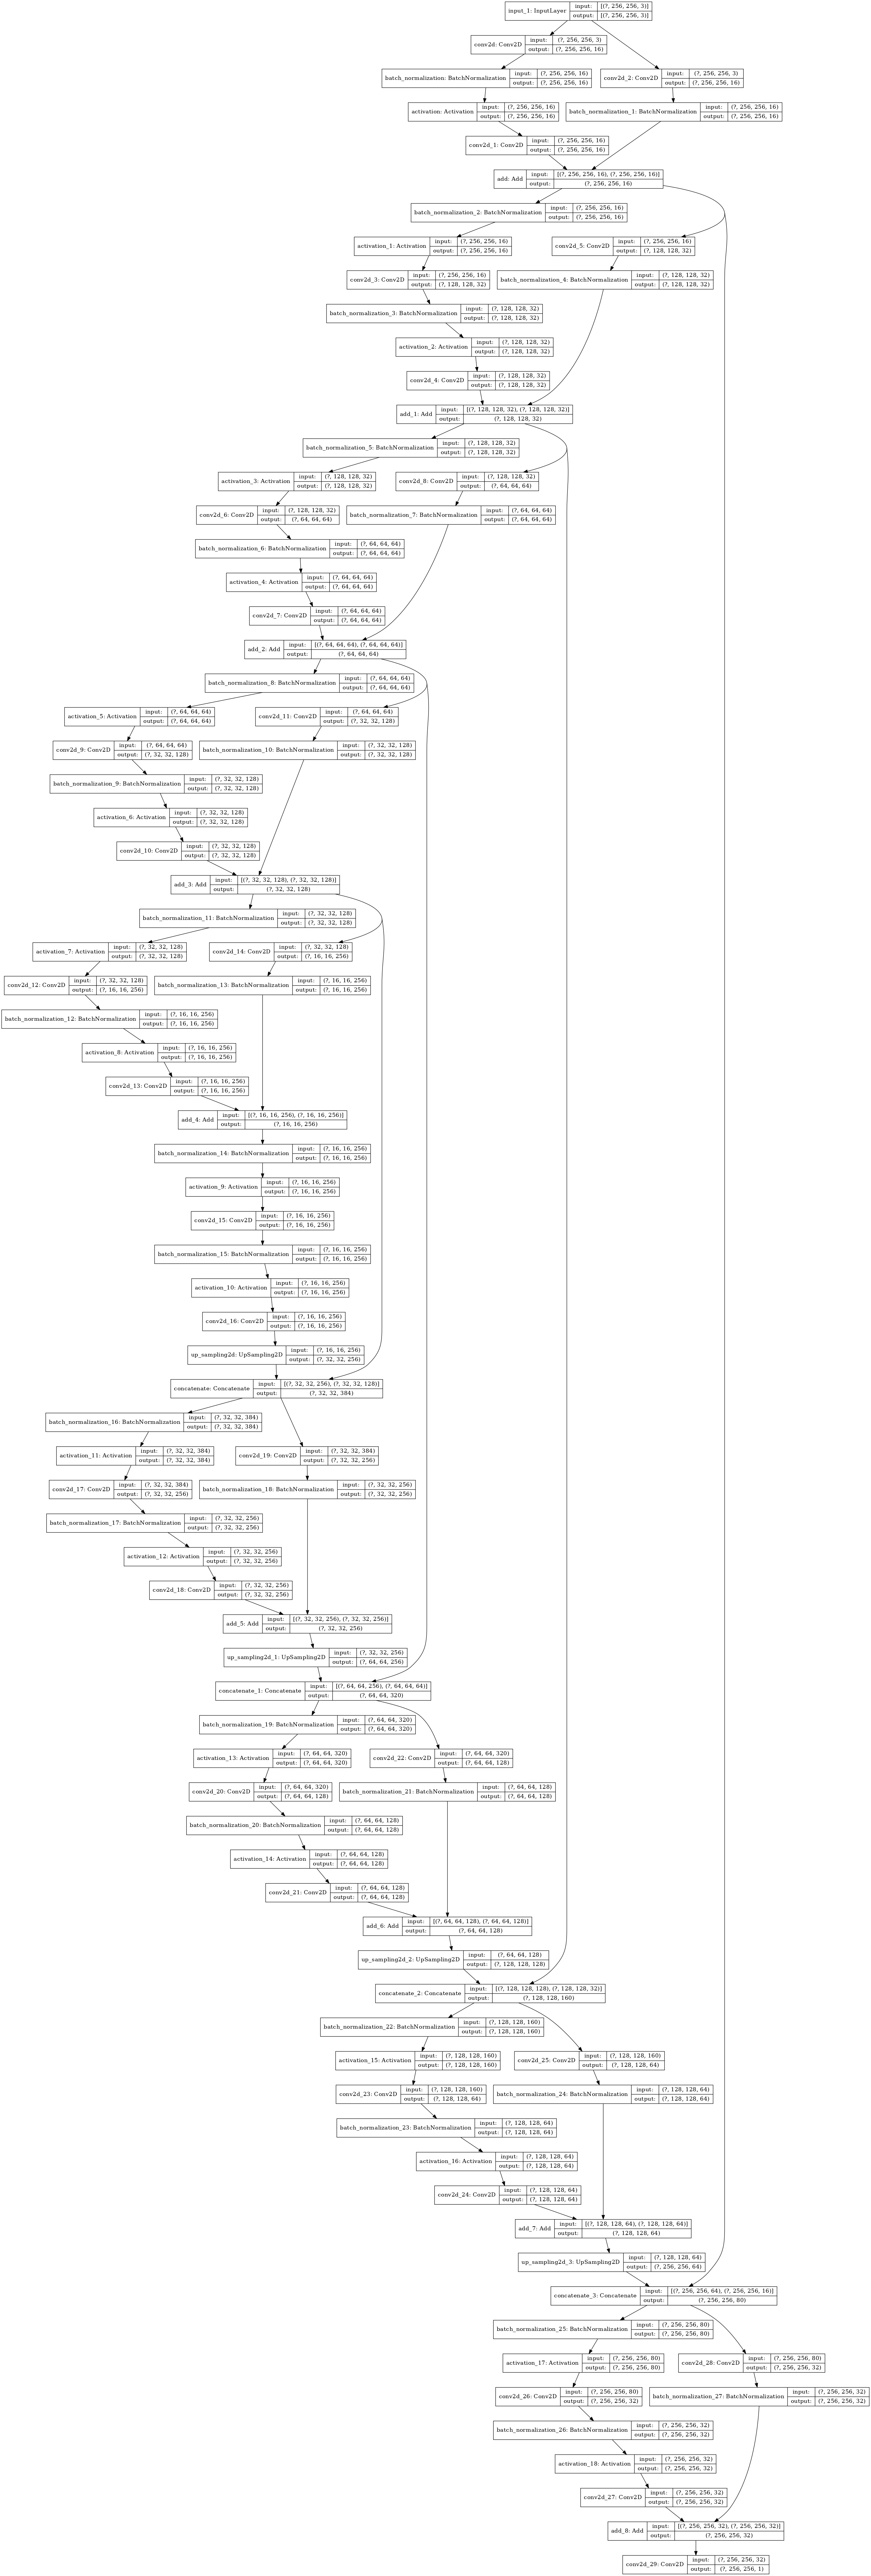

In [34]:
from tensorflow.keras.utils import  plot_model

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=100,
)

# Loss
# &
# Compile

In [35]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou



In [36]:
def lr_schedule(epoch):

    lr =0.0035
    if epoch >150:
        lr *=2**-1
    elif epoch >80:
        lr *=2**(-1)
    elif epoch >50:
        lr *=2**(-1)
    elif epoch >30:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

In [38]:

import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


In [39]:
import tensorflow as tf
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)

#from tensorflow.keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=4)

from tensorflow.python.client import device_lib
#from tensorflow.contrib.compiler import xla
device_lib.list_local_devices()


from tensorflow.keras.utils import multi_gpu_model
model = multi_gpu_model(model, gpus=4)

model.compile(optimizer =optimiser , loss = dice_coef_loss, metrics = ['accuracy', IOU, dice_coef])

Learning rate:  0.0035


In [40]:
model.save('/data/datasets/crack/Crack500/Adam_and_beyond.h5')

# Training

In [41]:
train_steps = len(train_image_files)//batch_size
valid_steps = len(valid_image_files)//batch_size

history = model.fit(
    tg, 
    steps_per_epoch=train_steps,
    initial_epoch = 0,
    epochs=100,
    validation_data = vg,    
    validation_steps = valid_steps,callbacks=callbacks)

Learning rate:  0.0035
Epoch 1/100
30/30 [==============================] - 46s 2s/step - loss: 0.5066 - acc: 0.9450 - IOU: 0.3499 - dice_coef: 0.4934 - val_loss: 0.9994 - val_acc: 0.9663 - val_IOU: 3.1122e-05 - val_dice_coef: 5.8267e-04
Learning rate:  0.0035
Epoch 2/100
30/30 [==============================] - 16s 539ms/step - loss: 0.4060 - acc: 0.9724 - IOU: 0.4301 - dice_coef: 0.5940 - val_loss: 0.9955 - val_acc: 0.9664 - val_IOU: 0.0021 - val_dice_coef: 0.0045
Learning rate:  0.0035
Epoch 3/100
30/30 [==============================] - 16s 536ms/step - loss: 0.3750 - acc: 0.9760 - IOU: 0.4617 - dice_coef: 0.6250 - val_loss: 0.4325 - val_acc: 0.9720 - val_IOU: 0.4028 - val_dice_coef: 0.5675
Learning rate:  0.0035
Epoch 4/100
30/30 [==============================] - 16s 542ms/step - loss: 0.3710 - acc: 0.9761 - IOU: 0.4649 - dice_coef: 0.6290 - val_loss: 0.5072 - val_acc: 0.9574 - val_IOU: 0.3385 - val_dice_coef: 0.4928
Learning rate:  0.0035
Epoch 5/100
30/30 [=====================

Learning rate:  0.0035
Epoch 24/100
30/30 [==============================] - 16s 538ms/step - loss: 0.3082 - acc: 0.9792 - IOU: 0.5334 - dice_coef: 0.6918 - val_loss: 0.2694 - val_acc: 0.9807 - val_IOU: 0.5796 - val_dice_coef: 0.7306
Learning rate:  0.0035
Epoch 25/100
30/30 [==============================] - 16s 539ms/step - loss: 0.3143 - acc: 0.9800 - IOU: 0.5259 - dice_coef: 0.6857 - val_loss: 0.3393 - val_acc: 0.9719 - val_IOU: 0.5016 - val_dice_coef: 0.6607
Learning rate:  0.0035
Epoch 26/100
30/30 [==============================] - 16s 537ms/step - loss: 0.3060 - acc: 0.9805 - IOU: 0.5365 - dice_coef: 0.6940 - val_loss: 0.3081 - val_acc: 0.9772 - val_IOU: 0.5331 - val_dice_coef: 0.6919
Learning rate:  0.0035
Epoch 27/100
30/30 [==============================] - 16s 541ms/step - loss: 0.3079 - acc: 0.9808 - IOU: 0.5335 - dice_coef: 0.6921 - val_loss: 0.3978 - val_acc: 0.9584 - val_IOU: 0.4397 - val_dice_coef: 0.6022
Learning rate:  0.0035
Epoch 28/100
30/30 [=====================

Learning rate:  0.00175
Epoch 47/100
30/30 [==============================] - 16s 539ms/step - loss: 0.2921 - acc: 0.9812 - IOU: 0.5523 - dice_coef: 0.7079 - val_loss: 0.3341 - val_acc: 0.9687 - val_IOU: 0.5081 - val_dice_coef: 0.6659
Learning rate:  0.00175
Epoch 48/100
30/30 [==============================] - 16s 537ms/step - loss: 0.2885 - acc: 0.9819 - IOU: 0.5571 - dice_coef: 0.7115 - val_loss: 0.3320 - val_acc: 0.9692 - val_IOU: 0.5118 - val_dice_coef: 0.6680
Learning rate:  0.00175
Epoch 49/100
30/30 [==============================] - 16s 538ms/step - loss: 0.2903 - acc: 0.9814 - IOU: 0.5542 - dice_coef: 0.7097 - val_loss: 0.3124 - val_acc: 0.9735 - val_IOU: 0.5312 - val_dice_coef: 0.6876
Learning rate:  0.00175
Epoch 50/100
30/30 [==============================] - 16s 534ms/step - loss: 0.2852 - acc: 0.9819 - IOU: 0.5609 - dice_coef: 0.7148 - val_loss: 0.3006 - val_acc: 0.9759 - val_IOU: 0.5457 - val_dice_coef: 0.6994
Learning rate:  0.00175
Epoch 51/100
30/30 [================

Learning rate:  0.00175
Epoch 70/100
30/30 [==============================] - 16s 537ms/step - loss: 0.2845 - acc: 0.9820 - IOU: 0.5611 - dice_coef: 0.7155 - val_loss: 0.3271 - val_acc: 0.9679 - val_IOU: 0.5195 - val_dice_coef: 0.6729
Learning rate:  0.00175
Epoch 71/100
30/30 [==============================] - 16s 538ms/step - loss: 0.2753 - acc: 0.9828 - IOU: 0.5720 - dice_coef: 0.7247 - val_loss: 0.2422 - val_acc: 0.9844 - val_IOU: 0.6146 - val_dice_coef: 0.7578
Learning rate:  0.00175
Epoch 72/100
30/30 [==============================] - 16s 539ms/step - loss: 0.2732 - acc: 0.9829 - IOU: 0.5747 - dice_coef: 0.7268 - val_loss: 0.3144 - val_acc: 0.9719 - val_IOU: 0.5371 - val_dice_coef: 0.6856
Learning rate:  0.00175
Epoch 73/100
30/30 [==============================] - 16s 539ms/step - loss: 0.2770 - acc: 0.9820 - IOU: 0.5703 - dice_coef: 0.7230 - val_loss: 0.2690 - val_acc: 0.9795 - val_IOU: 0.5835 - val_dice_coef: 0.7310
Learning rate:  0.00175
Epoch 74/100
30/30 [================

Learning rate:  0.00175
Epoch 93/100
30/30 [==============================] - 16s 537ms/step - loss: 0.2761 - acc: 0.9823 - IOU: 0.5711 - dice_coef: 0.7239 - val_loss: 0.2741 - val_acc: 0.9778 - val_IOU: 0.5756 - val_dice_coef: 0.7259
Learning rate:  0.00175
Epoch 94/100
30/30 [==============================] - 16s 534ms/step - loss: 0.2696 - acc: 0.9824 - IOU: 0.5795 - dice_coef: 0.7304 - val_loss: 0.2646 - val_acc: 0.9812 - val_IOU: 0.5879 - val_dice_coef: 0.7354
Learning rate:  0.00175
Epoch 95/100
30/30 [==============================] - 16s 533ms/step - loss: 0.2694 - acc: 0.9831 - IOU: 0.5796 - dice_coef: 0.7306 - val_loss: 0.2711 - val_acc: 0.9812 - val_IOU: 0.5795 - val_dice_coef: 0.7289
Learning rate:  0.00175
Epoch 96/100
30/30 [==============================] - 16s 536ms/step - loss: 0.2734 - acc: 0.9826 - IOU: 0.5741 - dice_coef: 0.7266 - val_loss: 0.2717 - val_acc: 0.9813 - val_IOU: 0.5822 - val_dice_coef: 0.7283
Learning rate:  0.00175
Epoch 97/100
30/30 [================

In [43]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

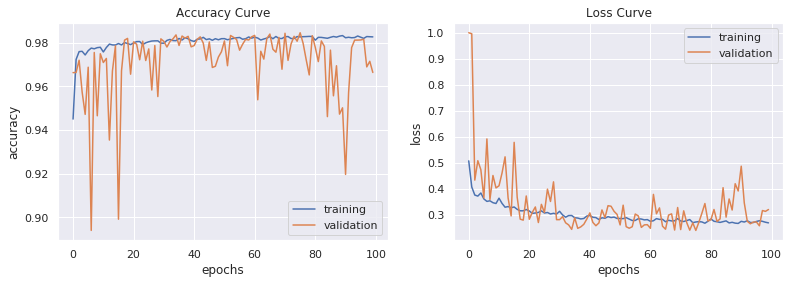

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [45]:
train_dice = history.history['dice_coef']
valid_dice = history.history['val_dice_coef']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

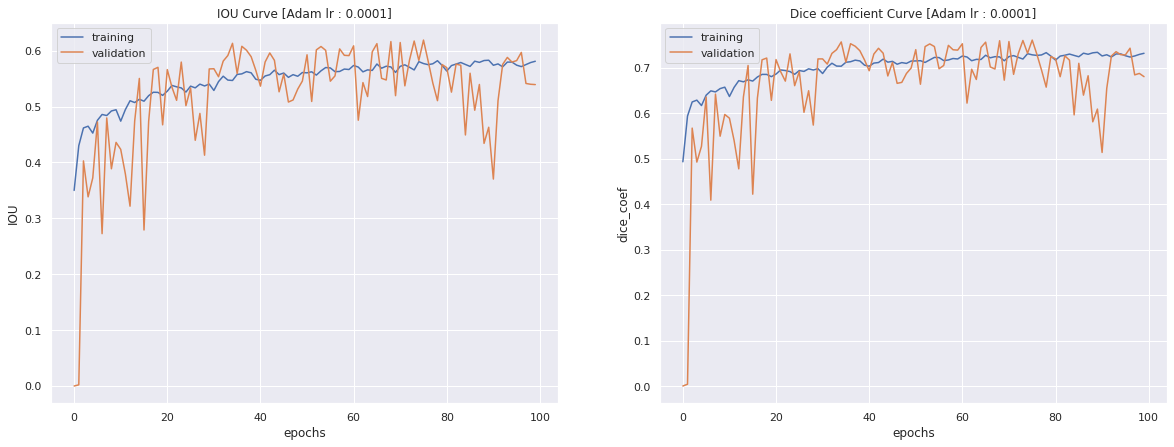

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve [Adam lr : 0.0001]')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve [Adam lr : 0.0001]')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()

## Testing

In [47]:
test_generator = Generator(valid_image_files, valid_mask_files, 396, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

In [48]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9664

Precision: 0.5007

Recall: 0.7600

F1-Score: 0.6037

Sensitivity: 0.7600

Specificity: 0.9736

AUC: 0.9017

IOU: 0.4323

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.99      0.97      0.98   6332913
        True       0.50      0.76      0.60    220687

    accuracy                           0.97   6553600
   macro avg       0.75      0.87      0.79   6553600
weighted avg       0.97      0.97      0.97   6553600



In [49]:
for i, j in test1_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [50]:
ttg = Generator(test_image_paths,test_mask_paths, batch_size, img_dim, augment = False)

In [51]:
for i, j in ttg:
  break

print(i.shape)
print(j.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)


In [52]:
test_generator1 = Generator(test_image_paths,test_mask_paths,1124, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

In [53]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9664

Precision: 0.5007

Recall: 0.7600

F1-Score: 0.6037

Sensitivity: 0.7600

Specificity: 0.9736

AUC: 0.9017

IOU: 0.4323

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.99      0.97      0.98   6332913
        True       0.50      0.76      0.60    220687

    accuracy                           0.97   6553600
   macro avg       0.75      0.87      0.79   6553600
weighted avg       0.97      0.97      0.97   6553600



In [54]:
def plot_image(i, predictions_array, img):
  img = img[i]

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])   
  indices = np.where(predictions_array!=[0])

  plt.imshow(img)#, cmap=plt.cm.binary)
  save_path = '/home/adip/crack_ws/src/datasets/Crack500/results/mask'
  cv2.imwrite(os.path.join(save_path, '{}.png'.format(i)), img)


TypeError: Invalid shape (256, 256, 1) for image data

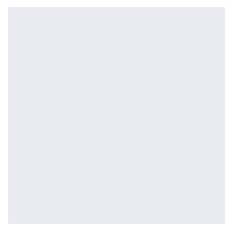

In [55]:
i = 1
plt.figure()
plt.plot()

plot_image(i,y_pred, y_pred)